# 1. Import Dependencies


In [3]:
import os
import pandas as pd



# 2. Data Loading
### 2.1 Define File Paths

In [4]:
BUSINESS_PLANNING = os.path.join('data', 'CensusBusinessPlanning')
business_files = os.listdir(BUSINESS_PLANNING)

QUARTERLY_EMPLOYMENT = os.path.join('data', 'QuarterlyCensusEmployment')
quarterly_employment_files = os.listdir(QUARTERLY_EMPLOYMENT)

YEARLY_EMPLOYMENT = os.path.join('data', 'YearlyCensusEmployment')
yearly_employmet_files = os.listdir(YEARLY_EMPLOYMENT)

### 2.2 Build Data Loading Function

In [5]:
def load_files(path, dir_list):
    data_frames = {}
    
    for file in dir_list:
        var = file.split(".")[0]
        file_path = os.path.join(path, file)
        
        if '.csv' in file:
            data_frames[var] = pd.read_csv(file_path, dtype=str, low_memory=False)
        elif '.xlsx' in file:
            print("Loading and converting file:", file)
            
            # Convert Excel to CSV
            df = pd.read_excel(file_path, sheet_name=0, engine='calamine')
            
            # Create CSV file path
            csv_file_path = os.path.join(path, f"{var}.csv")
            df.to_csv(csv_file_path, index=False)
            
            print(f"Converted {file} to CSV: {var}.csv")
            
            # Store the dataframe
            data_frames[var] = df
    
    return data_frames


### 2.3 Load in Files as Dictionaries

In [6]:
cbp_dict = load_files(BUSINESS_PLANNING, business_files)

q_emp_dict = load_files(QUARTERLY_EMPLOYMENT, quarterly_employment_files)

y_emp_dict = load_files(YEARLY_EMPLOYMENT, yearly_employmet_files)


### 2.4 Load in Other Files

In [7]:
county_gdp = pd.read_csv('data/CountyGDP.csv', dtype=str, low_memory=False, encoding='latin-1')

county_income = pd.read_csv("data/CountyIncome.csv", dtype = str, low_memory = False, encoding='latin-1' )

construction_permits = pd.read_csv("Data/ResidentialConstructionPermitsCounty.csv", dtype=str, low_memory = False, encoding='latin-1') 

# 3. Data Preprocessing

### 3.1 Census Business Planning

In [8]:
def standardize_cbp_columns(cbp_dict):
    """Remove unnecessary columns and standardize based on year"""
    for df in cbp_dict.keys():
        year = df[0:4]
        if int(year) < 2017:
            use = "2012"
        else:
            use = "2017"
        keep = ['GEO_ID', 'YEAR', 'NAME', f'NAICS{use}', f'NAICS{use}_LABEL',  
                'EMPSZES_LABEL', 'ESTAB', 'EMP', 'PAYANN']
        cbp_dict[df] = cbp_dict[df][keep]
    return cbp_dict

def remove_first_row(cbp_dict):
    """Remove first row from CBP"""
    try:
        for df in cbp_dict.keys():
            cbp_dict[df] = cbp_dict[df].drop(0)
    except:
        print("Row 0 already removed")
    return cbp_dict

def combine_dfs(dict):
    standardized_df = []
    for key, value in dict.items():
        df_copy = value.copy()
        df_copy = df_copy.rename(columns={
            "NAICS2012" : "NAICS", 
            "NAICS2017" : "NAICS", 
            "NAICS2012_LABEL" : "NAICS_LABEL", 
            "NAICS2017_LABEL" : "NAICS_LABEL"
        })

        standardized_df.append(df_copy)
    combined_df = pd.concat(standardized_df, ignore_index=True)
    return combined_df

cbp_dict = remove_first_row(cbp_dict)
cbp_dict = standardize_cbp_columns(cbp_dict)
cbp_df = combine_dfs(cbp_dict)

In [ ]:
state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY', 'District of Columbia': 'DC'
}

def filter_cbp(df):
    temp = df[df['EMPSZES_LABEL'] == "All establishments"]
    temp = temp[temp['NAICS_LABEL'].isin(['Total for all sectors', 'Retail trade', 'Accommodation and food services'])]
    return temp


# Filter for specific industries
cbp_df = filter_cbp(cbp_df)

# Seperate County and State from NAME
cbp_df[['County', 'State']] = cbp_df['NAME'].str.split(",", expand=True)
cbp_df['State'] = cbp_df['State'].str.strip().map(state_abbrev)
cbp_df = cbp_df.dropna(subset=['State'])
cbp_df = cbp_df.reset_index(drop=True)
cbp_df['County'] = cbp_df['County'].str.upper()


,GEO_ID,YEAR,NAME,NAICS,NAICS_LABEL,EMPSZES_LABEL,ESTAB,EMP,PAYANN,County,State
0,0500000US01001,2014,"Autauga County, Alabama",00,Total for all sectors,All establishments,817.0,10202.0,301156.0,AUTAUGA COUNTY,AL
1,0500000US01001,2014,"Autauga County, Alabama",44-45,Retail trade,All establishments,165.0,2525.0,58221.0,AUTAUGA COUNTY,AL
2,0500000US01001,2014,"Autauga County, Alabama",72,Accommodation and food services,All establishments,86.0,1973.0,27442.0,AUTAUGA COUNTY,AL
3,0500000US01003,2014,"Baldwin County, Alabama",00,Total for all sectors,All establishments,4969.0,56531.0,1749241.0,BALDWIN COUNTY,AL
4,0500000US01003,2014,"Baldwin County, Alabama",44-45,Retail trade,All establishments,975.0,13471.0,325675.0,BALDWIN COUNTY,AL


## 3.2 Quarterly Employment

In [ ]:
def process_quarterly_employment_data(q_emp_dict, state_abbrev):
   """
   Process all employment dataframes in dictionary and combine into one.
   
   Parameters:
   q_emp_dict: Dictionary with dataframe names as keys and dataframes as values
   state_abbrev: Dictionary mapping state names to abbreviations
   
   Returns:
   Combined processed dataframe
   """
   processed_dfs = []
   
   for key, df in q_emp_dict.items():
       temp = df.copy()
       temp = temp.dropna(subset=['St Name'])
       
       
       numeric_cols = temp.iloc[:, 14:17].apply(pd.to_numeric, errors='coerce')
       temp.loc[:, 'average_employment'] = numeric_cols.mean(axis=1)
       
       # Drop original columns and filter for counties
       temp = temp.drop(columns=temp.columns[14:17]) 
       temp = temp[temp["Area Type"] == "County"]
       
       # Split area into county and state
       temp[['County', 'State']] = temp['Area'].str.split(",", expand=True)
       temp['State'] = temp['State'].str.strip().map(state_abbrev)
       
       # Select and reorder columns
       temp = temp[['Year', 'Qtr','County', 'State','NAICS', 
                  'Area Type', 'Ownership', 'Industry', 'Status Code',
                  'Establishment Count', 'Total Quarterly Wages', 'Average Weekly Wage',
                  'Employment Location Quotient Relative to U.S.',
                  'Total Wage Location Quotient Relative to U.S.', 'average_employment']]
       
       processed_dfs.append(temp)
   
   # Combine all processed dataframes
   combined_df = pd.concat(processed_dfs, ignore_index=True)
   
   return combined_df


quarterly_employment_df = process_quarterly_employment_data(q_emp_dict, state_abbrev)
quarterly_employment_df['County'] = quarterly_employment_df['County'].str.upper()


,Year,Qtr,County,State,NAICS,Area Type,Ownership,Industry,Status Code,Establishment Count,Total Quarterly Wages,Average Weekly Wage,Employment Location Quotient Relative to U.S.,Total Wage Location Quotient Relative to U.S.,average_employment
0,2014,1,AUTAUGA COUNTY,AL,10,County,Total Covered,"Total, all industries",NaN,814,88969726,658,1.0,1.0,10397.666667
1,2014,1,AUTAUGA COUNTY,AL,10,County,Federal Government,"Total, all industries",NaN,11,1075338,981,0.4,0.4,84.333333
2,2014,1,AUTAUGA COUNTY,AL,10,County,State Government,"Total, all industries",NaN,18,4364570,721,1.32,1.46,465.666667
3,2014,1,AUTAUGA COUNTY,AL,10,County,Local Government,"Total, all industries",NaN,32,15929244,640,1.75,2.02,1915.333333
4,2014,1,AUTAUGA COUNTY,AL,10,County,Private,"Total, all industries",NaN,753,67600574,656,0.91,0.9,7932.333333


## 3.3 Yearly Employment

In [ ]:
def process_yearly_employment_data(y_emp_dict, state_abbrev):
   """
   Process all employment dataframes in dictionary and combine into one.
   
   Parameters:
   q_emp_dict: Dictionary with dataframe names as keys and dataframes as values
   state_abbrev: Dictionary mapping state names to abbreviations
   
   Returns:
   Combined processed dataframe
   """
   processed_dfs = []
   
   for key, df in y_emp_dict.items():
       temp = df.copy()
       temp = temp[temp["Area Type"] == "County"]
       
       # Split area into county and state
       temp[['County', 'State']] = temp['Area'].str.split(",", expand=True)
       temp['State'] = temp['State'].str.strip().map(state_abbrev)
       
       processed_dfs.append(temp)
   
   
   combined_df = pd.concat(processed_dfs, ignore_index=True)
   combined_df = combined_df[[ 'Year', 'Qtr', 'County', 'State','NAICS',
       'Area Type', 'Ownership', 'Industry',
       'Annual Average Status Code', 'Annual Average Establishment Count',
       'Annual Average Employment', 'Annual Total Wages',
       'Annual Average Weekly Wage', 'Annual Average Pay',
       'Employment Location Quotient Relative to U.S.',
       'Total Wage Location Quotient Relative to U.S.', ]]
   
   
   return combined_df

yearly_employment_df = process_yearly_employment_data(y_emp_dict, state_abbrev)
yearly_employment_df['County'] = yearly_employment_df['County'].str.upper()


,Year,Qtr,County,State,NAICS,Area Type,Ownership,Industry,Annual Average Status Code,Annual Average Establishment Count,Annual Average Employment,Annual Total Wages,Annual Average Weekly Wage,Annual Average Pay,Employment Location Quotient Relative to U.S.,Total Wage Location Quotient Relative to U.S.
0,2014,A,AUTAUGA COUNTY,AL,10,County,Total Covered,"Total, all industries",NaN,822,10458,357996403,658,34232,1.0,1.0
1,2014,A,AUTAUGA COUNTY,AL,10,County,Federal Government,"Total, all industries",NaN,12,83,4071222,949,49348,0.4,0.39
2,2014,A,AUTAUGA COUNTY,AL,10,County,State Government,"Total, all industries",NaN,18,474,20075442,815,42391,1.36,1.6
3,2014,A,AUTAUGA COUNTY,AL,10,County,Local Government,"Total, all industries",NaN,32,1910,66182496,666,34654,1.81,2.04
4,2014,A,AUTAUGA COUNTY,AL,10,County,Private,"Total, all industries",NaN,760,7992,267667243,644,33492,0.9,0.88


## 3.4 County Income and GDP

In [47]:
def process_county(county_df):
   """
   Process county dataframes by splitting GeoName into County and State,
   cleaning the data, and reordering columns.
   
   Parameters:
   df_df: DataFrame with county income data
   
   Returns:
   Processed DataFrame with cleaned County and State columns
   """
   df = county_df[['GeoFIPS', 'GeoName', 'TableName',
                                    'IndustryClassification', 'Description', 'Unit', '2014', '2015', '2016',
                                    '2017', '2018', '2019', '2020', '2021', '2022', '2023']].copy()
   
   # Filter to only rows that contain a comma
   df = df[df['GeoName'].str.contains(',', na=False)]
   
   # Split GeoName into County and State
   df[['County', 'State']] = df['GeoName'].str.split(",", n=1, expand=True)
   
   # Clean County and State columns
   df['County'] = df['County'].str.strip()
   df['State'] = df['State'].str.strip().str.replace('*', '', regex=False)
   df['County'] = df['County'] + " County"
   
   df = df[['GeoFIPS', 'GeoName', 'County', 'State',
                                 'Description', 'Unit', '2014', '2015', '2016',
                                 '2017', '2018', '2019', '2020', '2021', '2022', '2023']]
   
   return df

processed_income = process_county(county_income)
processed_income['County'] = processed_income['County'].str.upper()
processed_gdp = process_county(county_gdp)
processed_gdp['County'] = processed_gdp['County'].str.upper()


## 3.5 Construction

In [ ]:
import re

def prepare_permits(df, start_year=2014, end_year=2022):
    """
    Prepare permits data specifically for residential development impact forecasting
    
    Parameters:
    df: DataFrame with building permits data
    start_year: Starting year for analysis (default: 2014)
    end_year: Ending year for analysis (default: 2022)
    """
    
    # Base identification columns
    base_cols = ['GEOID', 'STATE', 'COUNTY', 'NAME', 'STATE_NAME']
    
    # Validate required columns exist
    missing_cols = [col for col in base_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    surge_cols = []
   
    for year in range(start_year, end_year + 1):
        if year == 2022:
            # Special case for 2022 with different column name
            col_name = f'MULTIFAMILY_PERMITS_5_OR_MORE_{year}'
        else:
            col_name = f'MULTIFAMILY_PERMITS_5_OR_MORE_UNITS_{year}'
        
        if col_name in df.columns:
            surge_cols.append(col_name)
        else:
            print(f"Warning: Column {col_name} not found in dataset")
    
    if not surge_cols:
        raise ValueError(f"No 5+ unit permit columns found for years {start_year}-{end_year}")
        
    project_df = df[base_cols + surge_cols].copy()
    
    # Reshape to long format for time series analysis
    project_long = project_df.melt(
        id_vars=base_cols,
        value_vars=surge_cols,
        var_name='year_col',
        value_name='permits_5plus'
    )
    
    project_long['year'] = project_long['year_col'].str.extract(r'(\d{4})').astype(int)
    project_long = project_long.drop('year_col', axis=1)
    
    # Handle missing values and ensure proper data types
    project_long['permits_5plus'] = pd.to_numeric(project_long['permits_5plus'], errors='coerce').fillna(0)
    
    # Sort by location and year for better organization
    project_long = project_long.sort_values(['STATE_NAME', 'NAME', 'year']).reset_index(drop=True)
    return project_long

def fix_permits(df, state_abbrev):
    df = df[['NAME','STATE_NAME', 'year', 'permits_5plus']].copy()
    df['NAME'] = df['NAME'].str.upper()
    df['STATE_NAME'] = df['STATE_NAME'].str.strip().map(state_abbrev)

    return df

const_permits = prepare_permits(construction_permits)
const_permits = fix_permits(const_permits, state_abbrev)

,NAME,STATE_NAME,year,permits_5plus
0,AUTAUGA,AL,2014,0.0
1,AUTAUGA,AL,2015,0.0
2,AUTAUGA,AL,2016,0.0
3,AUTAUGA,AL,2017,0.0
4,AUTAUGA,AL,2018,0.0
5,AUTAUGA,AL,2019,0.0
6,AUTAUGA,AL,2020,0.0
7,AUTAUGA,AL,2021,0.0
8,AUTAUGA,AL,2022,0.0
9,BALDWIN,AL,2014,0.0


# 4. Data Exploration

## 4.1 Census Business Planning

In [67]:
# Convert string columns to numeric
numeric_cols = ['YEAR', 'ESTAB', 'EMP', 'PAYANN']

for col in numeric_cols:
    cbp_df[col] = pd.to_numeric(cbp_df[col], errors='coerce')

    # Check the conversion worked
print("Data types after conversion:")
print(cbp_df[numeric_cols].dtypes)
print("\nAny missing values created?")
print(cbp_df[numeric_cols].isnull().sum())

Data types after conversion:
YEAR        int64
ESTAB     float64
EMP       float64
PAYANN    float64
dtype: object

Any missing values created?
YEAR        0
ESTAB       1
EMP       652
PAYANN    433
dtype: int64


#### Functions to create visuals 

In [72]:
import pandas as pd
from IPython.display import display

def get_sector_summary(results):
    """
    Generate a summary of the employment analysis results.
    """
    
    summary_data = []
    
    sector_mapping = {
        'all_sectors': 'All Sectors',
        'retail_trade': 'Retail Trade',
        'accommodation_food': 'Accommodation & Food Services'
    }
    
    for key, sector_name in sector_mapping.items():
        if results[key] is not None and not results[key].empty:
            data = results[key]
            summary_data.append({
                'Sector': sector_name,
                'Counties_Analyzed': len(data),
                'Max_Employment': data['EMP'].max(),
                'Min_Employment': data['EMP'].min(),
                'Avg_Employment': data['EMP'].mean(),
                'Top_County': f"{data.iloc[0]['County']}, {data.iloc[0]['State']}"
            })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

def plot_top_counties(results, sector='all_sectors', top_n=10):
    """
    Create a horizontal bar plot of top counties by employment.

    """
    
    import matplotlib.pyplot as plt
    
    if results[sector] is None or results[sector].empty:
        print(f"No data available for sector: {sector}")
        return
    
    data = results[sector].head(top_n)
    
    # Create labels with county and state
    labels = [f"{row['County']}, {row['State']}" for _, row in data.iterrows()]
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    bars = plt.barh(range(len(data)), data['EMP'], color='steelblue', alpha=0.7)
    
    # Customize the plot
    plt.yticks(range(len(data)), labels)
    plt.xlabel('Average Employment')
    plt.title(f'Top {top_n} Counties by Average Employment - {sector.replace("_", " ").title()}')
    plt.gca().invert_yaxis()  # Highest values at the top
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, data['EMP'])):
        plt.text(bar.get_width() + max(data['EMP']) * 0.01, 
                bar.get_y() + bar.get_height()/2, 
                f'{value:,.0f}', 
                ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

def get_employment_summary_stats(cbp_df, sectors=['Total for all sectors', 'Retail trade', 'Accommodation and food services']):
    """
    Get summary statistics for employment distributions across different sectors using ALL data.
    """
    
    # Group data (same as in analyze_county_employment but use ALL data)
    cbp_group_county = cbp_df.groupby(['County', 'State', 'NAICS_LABEL'])['EMP'].mean().reset_index()
    
    summary_data = []
    
    for sector in sectors:
        sector_data = cbp_group_county[cbp_group_county['NAICS_LABEL'] == sector]
        
        if not sector_data.empty:
            # Remove any NaN or infinite values
            clean_data = sector_data['EMP'].dropna()
            clean_data = clean_data[clean_data != float('inf')]
            clean_data = clean_data[clean_data != float('-inf')]
            
            if len(clean_data) > 0:
                summary_data.append({
                    'Sector': sector,
                    'Count': len(clean_data),
                    'Mean': clean_data.mean(),
                    'Median': clean_data.median(),
                    'Std': clean_data.std(),
                    'Min': clean_data.min(),
                    'Max': clean_data.max(),
                    'Q1': clean_data.quantile(0.25),
                    'Q3': clean_data.quantile(0.75)
                })
            else:
                print(f"No valid data for sector: {sector}")
        else:
            print(f"No data found for sector: {sector}")
    
    if summary_data:
        return pd.DataFrame(summary_data)
    else:
        print("No data available for any of the specified sectors")
        return pd.DataFrame()


In [71]:
def filter_down_counties(df, top_n=500):
    # Group by county with average employment since 2014
    df_group_county = df.groupby(['County', 'State', 'NAICS_LABEL'])['EMP'].mean().reset_index()

    # Filter to all sectors and keep top n
    all_sectors = df_group_county[df_group_county['NAICS_LABEL'] == "Total for all sectors"]
    all_sectors = all_sectors.nlargest(top_n, 'EMP')

    # Get list of top n counties
    counties = all_sectors['County'].to_list()
    states = all_sectors['State'].to_list()

    # Create set of (county, state) tuples
    top_county_state = set(zip(counties, states))

    # Filter Retail Trade
    retail_trade = df_group_county[
        (df_group_county['NAICS_LABEL'] == "Retail trade") &
        (df_group_county.apply(lambda row: (row['County'], row['State']) in top_county_state, axis=1))
    ].sort_values("EMP", ascending=False)

    # Filter Accommodation and Food Services
    accommodation_food = df_group_county[
        (df_group_county['NAICS_LABEL'] == "Accommodation and food services") &
        (df_group_county.apply(lambda row: (row['County'], row['State']) in top_county_state, axis=1))
    ].sort_values("EMP", ascending=False)

    print("Retail Trade sample:")
    print(retail_trade.head())

    print("Accommodation and Food Services sample:")
    print(accommodation_food.head())

    results = {
        'grouped_data': df_group_county,
        'all_sectors': all_sectors,
        'retail_trade': retail_trade,
        'accommodation_food': accommodation_food
    }

    return results


In [74]:
results = filter_down_counties(cbp_df, top_n=500)

# Get summary statistics
summary = get_sector_summary(results)
print("\nEmployment Analysis Summary")
print("=" * 30)
display(summary)

Retail Trade sample:
                  County State   NAICS_LABEL       EMP
5141  LOS ANGELES COUNTY    CA  Retail trade  416644.2
1889         COOK COUNTY    IL  Retail trade  227503.3
5355     MARICOPA COUNTY    AZ  Retail trade  215957.9
3637       HARRIS COUNTY    TX  Retail trade  211252.6
6429       ORANGE COUNTY    CA  Retail trade  150788.0
Accommodation and Food Services sample:
                  County State                      NAICS_LABEL       EMP
5140  LOS ANGELES COUNTY    CA  Accommodation and food services  436935.9
1585        CLARK COUNTY    NV  Accommodation and food services  260447.6
1888         COOK COUNTY    IL  Accommodation and food services  234937.3
6194     NEW YORK COUNTY    NY  Accommodation and food services  225269.8
3636       HARRIS COUNTY    TX  Accommodation and food services  210963.5

Employment Analysis Summary


,Sector,Counties_Analyzed,Max_Employment,Min_Employment,Avg_Employment,Top_County
0,All Sectors,500,3883290.7,43462.8,207488.035889,"LOS ANGELES COUNTY, CA"
1,Retail Trade,500,416644.2,4757.9,24895.315950,"LOS ANGELES COUNTY, CA"
2,Accommodation & Food Services,500,436935.9,3427.6,22425.683650,"LOS ANGELES COUNTY, CA"


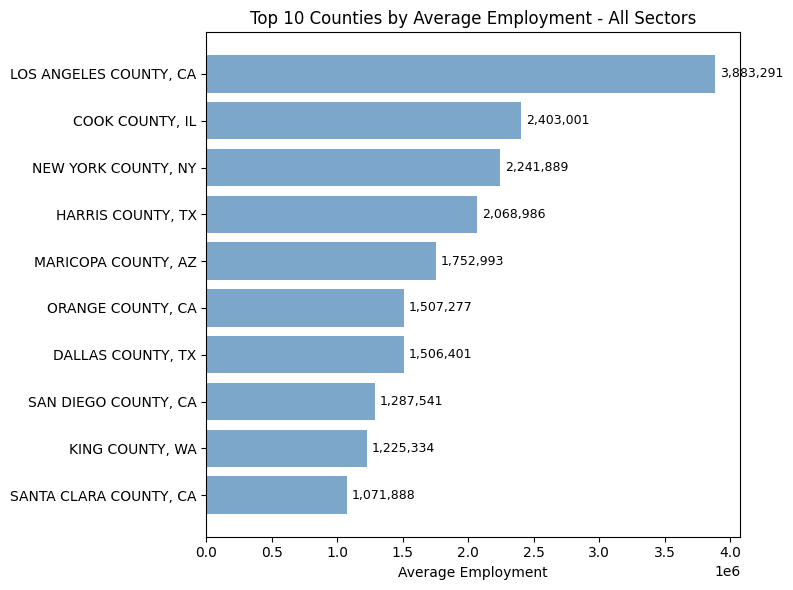

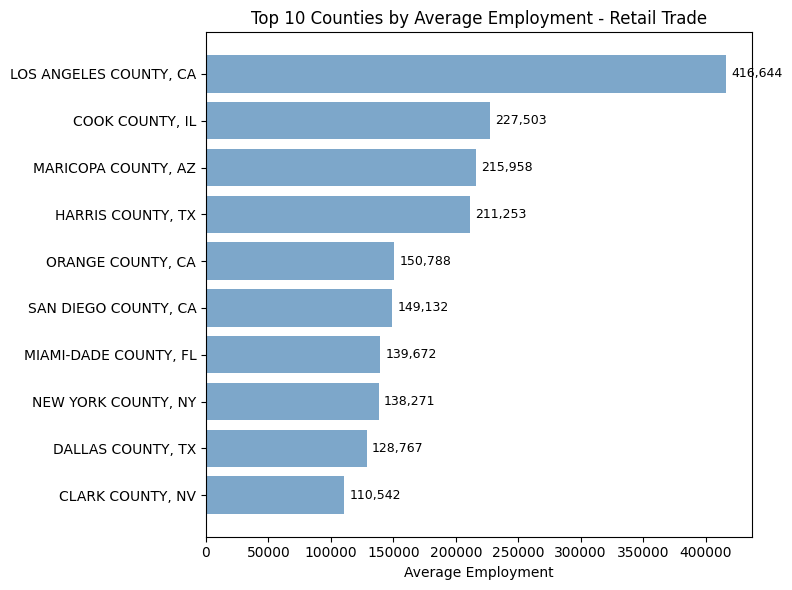

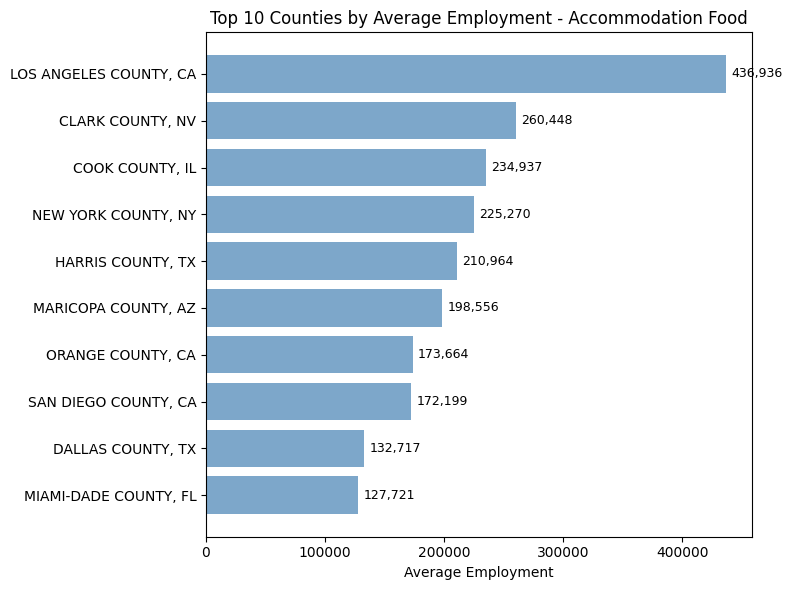

In [75]:
# Plot results - these use the top N from results
plot_top_counties(results, sector='all_sectors', top_n=10)
plot_top_counties(results, sector='retail_trade', top_n=10)
plot_top_counties(results, sector='accommodation_food', top_n=10)

In [76]:
# Get summary statistics for ALL counties in each sector
full_stats = get_employment_summary_stats(cbp_df)
print("\nFull Employment Statistics (All Counties)")
print("=" * 40)
display(full_stats)


Full Employment Statistics (All Counties)


,Sector,Count,Mean,Median,Std,Min,Max,Q1,Q3
0,Total for all sectors,3154,39918.225419,6594.600000,145621.426459,21.000000,3883290.7,2145.150000,20979.15
1,Retail trade,3144,5061.406268,1014.911111,15474.383312,5.666667,416644.2,323.325000,3272.70
2,Accommodation and food services,3118,4452.373130,742.200000,16099.191775,1.000000,436935.9,214.566667,2601.75


In [89]:
#  Generate lists to focus on for analysis

reducedCounties = results['all_sectors']['County'].tolist()
reducedStates = results['all_sectors']['State'].tolist()
reducedFull = list(zip(reducedCounties, reducedStates))
reducedFull

[('LOS ANGELES COUNTY', 'CA'),
 ('COOK COUNTY', 'IL'),
 ('NEW YORK COUNTY', 'NY'),
 ('HARRIS COUNTY', 'TX'),
 ('MARICOPA COUNTY', 'AZ'),
 ('ORANGE COUNTY', 'CA'),
 ('DALLAS COUNTY', 'TX'),
 ('SAN DIEGO COUNTY', 'CA'),
 ('KING COUNTY', 'WA'),
 ('SANTA CLARA COUNTY', 'CA'),
 ('MIAMI-DADE COUNTY', 'FL'),
 ('MIDDLESEX COUNTY', 'MA'),
 ('HENNEPIN COUNTY', 'MN'),
 ('CLARK COUNTY', 'NV'),
 ('FULTON COUNTY', 'GA'),
 ('TARRANT COUNTY', 'TX'),
 ('BEXAR COUNTY', 'TX'),
 ('ORANGE COUNTY', 'FL'),
 ('BROWARD COUNTY', 'FL'),
 ('OAKLAND COUNTY', 'MI'),
 ('ALLEGHENY COUNTY', 'PA'),
 ('ALAMEDA COUNTY', 'CA'),
 ('SAN FRANCISCO COUNTY', 'CA'),
 ('CUYAHOGA COUNTY', 'OH'),
 ('FRANKLIN COUNTY', 'OH'),
 ('KINGS COUNTY', 'NY'),
 ('PHILADELPHIA COUNTY', 'PA'),
 ('WAYNE COUNTY', 'MI'),
 ('MECKLENBURG COUNTY', 'NC'),
 ('SUFFOLK COUNTY', 'MA'),
 ('FAIRFAX COUNTY', 'VA'),
 ('TRAVIS COUNTY', 'TX'),
 ('SAN BERNARDINO COUNTY', 'CA'),
 ('HILLSBOROUGH COUNTY', 'FL'),
 ('SALT LAKE COUNTY', 'UT'),
 ('ST. LOUIS COUNTY', 'M

## 4.2 Quarterly Employment

In [97]:
def filter_employment(df, reducedFull):
    df = df.copy()
    filter_index = pd.MultiIndex.from_tuples(reducedFull, names=['County', 'State'])
    filtered_df = df[df.set_index(['County', 'State']).index.isnin(filter_index)].reset_index(drop=True)
    return filtered_df

filter_employment(quarterly_employment_df, reducedFull)

AttributeError: 'MultiIndex' object has no attribute 'isnin'

In [94]:
quarterly_employment_df.head()

,Year,Qtr,County,State,NAICS,Area Type,Ownership,Industry,Status Code,Establishment Count,Total Quarterly Wages,Average Weekly Wage,Employment Location Quotient Relative to U.S.,Total Wage Location Quotient Relative to U.S.,average_employment
0,2014,1,AUTAUGA COUNTY,AL,10,County,Total Covered,"Total, all industries",NaN,814,88969726,658,1.0,1.0,10397.666667
1,2014,1,AUTAUGA COUNTY,AL,10,County,Federal Government,"Total, all industries",NaN,11,1075338,981,0.4,0.4,84.333333
2,2014,1,AUTAUGA COUNTY,AL,10,County,State Government,"Total, all industries",NaN,18,4364570,721,1.32,1.46,465.666667
3,2014,1,AUTAUGA COUNTY,AL,10,County,Local Government,"Total, all industries",NaN,32,15929244,640,1.75,2.02,1915.333333
4,2014,1,AUTAUGA COUNTY,AL,10,County,Private,"Total, all industries",NaN,753,67600574,656,0.91,0.9,7932.333333


In [29]:
countyTemp = yearly_employment_df['County'].tolist()
new = list(map(str.lower, countyTemp))

stateTemp = yearly_employment_df['State'].tolist()
tempzip = list(zip(new, stateTemp))

temp1 = cbp_df['County'].tolist()
new1 = list(map(str.lower, temp1))
temp2 = cbp_df['State'].tolist()
tempzip1 = list(zip(new1, temp2))


ressy = list(set(tempzip) ^ set(tempzip1))
ressy

[('aleutian west census area', 'AK'),
 ('unknown or undefined', 'NM'),
 ('unknown or undefined', 'MD'),
 ('unknown or undefined', 'IA'),
 ('district of columbia', 'DC'),
 ('yakutat borough', 'AK'),
 ("o'brien county", 'IA'),
 ('unknown or undefined', 'OK'),
 ('unknown or undefined', 'ID'),
 ('juneau borough', 'AK'),
 ('unknown or undefined', 'AL'),
 ('unknown or undefined', 'VA'),
 ('unknown or undefined', 'AK'),
 ('unknown or undefined', 'NJ'),
 ('maui + kalawao county', 'HI'),
 ('unknown or undefined', 'NC'),
 ('unknown or undefined', 'OR'),
 ('unknown or undefined', 'VT'),
 ('unknown or undefined', 'WI'),
 ('unknown or undefined', 'SD'),
 ('unknown or undefined', 'NH'),
 ('unknown or undefined', 'OH'),
 ('unknown or undefined', 'LA'),
 ('dewitt county', 'IL'),
 ('unknown or undefined', 'MN'),
 ('unknown or undefined', 'MA'),
 ('unknown or undefined', 'WY'),
 ('unknown or undefined', 'MS'),
 ('unknown or undefined', 'HI'),
 ('unknown or undefined', 'TN'),
 ('dona ana county', 'NM'),


608710


In [ ]:
processed_gdp.head()

,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,1970,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,"""00000""",United States,,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,791229000,855525000,...,14778160000,15467113000,15884741000,16658962000,17514402000,18349584000,19600945000,21403979000,22077232000,23380269000
1,"""00000""",United States,,CAINC1,2,...,Population (persons) 1/,Number of persons,201298000,203798722,...,319257560,321815121,324353340,326608609,328529577,330226227,331526933,332048977,333271411,334914895
2,"""00000""",United States,,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3931,4198,...,46289,48062,48974,51006,53311,55567,59123,64460,66244,69810
3,"""01000""",Alabama,5,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,9737715,10628318,...,179487109,187474744,190871820,197963769,205674190,215151792,230732163,254960435,262235600,276925551
4,"""01000""",Alabama,5,CAINC1,2,...,Population (persons) 1/,Number of persons,3440000,3449846,...,4887757,4909177,4931579,4953096,4977088,5003778,5031864,5050380,5073903,5108468


In [167]:

construction_permits.head()

,ï»¿OBJECTID,GEOID,STATE,COUNTY,NAME,STUSAB,STATE_NAME,ALL_PERMITS_1980,SINGLE_FAMILY_PERMITS_1980,ALL_MULTIFAMILY_PERMITS_1980,...,MULTIFAMILY_PERMITS_3_4_UNITS_2021,MULTIFAMILY_PERMITS_5_OR_MORE_UNITS_2021,ALL_PERMITS_2022,SINGLE_FAMILY_PERMITS_2022,ALL_MULTIFAMILY_PERMITS_2022,MULTIFAMILY_PERMITS_2_UNITS_2022,MULTIFAMILY_PERMITS_3_4_UNIT_2022,MULTIFAMILY_PERMITS_5_OR_MORE_2022,Shape__Area,Shape__Length
0,1,53021,53,021,Franklin,WA,Washington,185,81,104,...,0,5,644,423,221,16,4,201,6923130082.625,426054.288996553
1,2,04017,04,017,Navajo,AZ,Arizona,563,511,52,...,8,0,580,568,12,8,4,0,38923009754.332,1146736.97994503
2,3,49051,49,051,Wasatch,UT,Utah,106,104,2,...,0,277,1009,991,18,0,6,12,5381081990.32813,436578.667793926
3,4,49033,49,033,Rich,UT,Utah,48,48,NaN,...,0,0,71,71,0,0,0,0,5040539368.93359,399384.213538217
4,5,49043,49,043,Summit,UT,Utah,525,294,231,...,30,123,560,470,90,0,0,90,8532139884.24609,628571.782229806


# FIPS Code Merging

# Development Surge Indicator Creation

# Quarterly Frequency Standardization

# Feature Engineering (PDFM + Economic Variables)

# Train/Test Split

# TimesFM Model Setup

# Baseline Forecasting

# Treatment Effect Analysis

# Model Validation & Backtesting

# Insights & Visualization

# Dashboard Prep